导包

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import math
import random

获取主数据集
test_data 为不可见数据集

In [2]:
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)

data = pd.read_csv('./Image_classification_data/data_labels_mainData.csv')
data['isCancerous'] = data['isCancerous'].astype(str)
data['cellType'] = data['cellType'].astype(str)
undivided_train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(undivided_train_data, test_size=0.2, random_state=42)

([0, 1], [Text(0, 0, '0'), Text(1, 0, '1')])

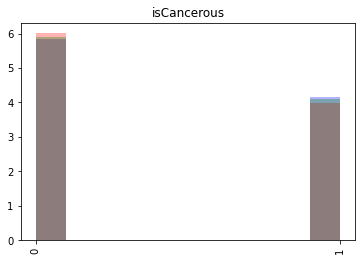

In [3]:
plt.hist(train_data['isCancerous'], alpha=0.3, color='b', label='Train', density=True)
plt.hist(test_data['isCancerous'], alpha=0.3, color='r', label='Test',  density=True)
plt.hist(val_data['isCancerous'], alpha=0.3, color='g', label='Val',  density=True)
plt.title('isCancerous')
plt.xticks(rotation='vertical')

([0, 1, 2, 3],
 [Text(0, 0, '1'), Text(1, 0, '0'), Text(2, 0, '2'), Text(3, 0, '3')])

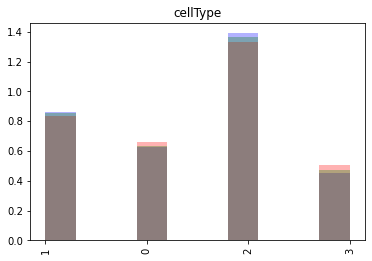

In [4]:
plt.hist(train_data['cellType'], alpha=0.3, color='b', label='Train', density=True)
plt.hist(test_data['cellType'], alpha=0.3, color='r', label='Test',  density=True)
plt.hist(val_data['cellType'], alpha=0.3, color='g', density=True)
plt.title('cellType')
plt.xticks(rotation='vertical')

In [5]:
class_samples_isCancerous = train_data['isCancerous'].value_counts()
total_samples = np.sum(class_samples_isCancerous)
class_weights_isCancerous = total_samples / class_samples_isCancerous
class_weight_dict_isCancerous = {int(k): v for k, v in class_weights_isCancerous.to_dict().items()}

class_samples_cellType = train_data['cellType'].value_counts()
total_samples = np.sum(class_samples_cellType)
class_weights_cellType = total_samples / class_samples_cellType
class_weight_dict_cellType = {int(k): v for k, v in class_weights_cellType.to_dict().items()}

In [6]:
class CustomImageDataGenerator(tf.keras.preprocessing.image.ImageDataGenerator):
    def __init__(self, num_augmentations=3, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.num_augmentations = num_augmentations

    def apply_transform(self, x, transform_parameters):
        augmentations = [
            "theta",
            "tx",
            "ty",
            "shear",
            "zx",
            "zy",
            "flip_horizontal",
            "flip_vertical",
            "brightness",
        ]

        selected_augmentations = random.sample(augmentations, self.num_augmentations)
        filtered_transform_parameters = {
            key: value for key, value in transform_parameters.items() if key in selected_augmentations
        }

        return super().apply_transform(x, filtered_transform_parameters)

train_datagen = CustomImageDataGenerator(
    num_augmentations=3,
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.2,1.0],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

In [7]:
batch_size = 32
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

train_isCancerous_generator = train_datagen.flow_from_dataframe(
    train_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='binary')

val_isCancerous_generator = val_datagen.flow_from_dataframe(
    val_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='binary')

test_isCancerous_generator = test_datagen.flow_from_dataframe(
    test_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='isCancerous',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='binary')

Found 6332 validated image filenames belonging to 2 classes.
Found 1584 validated image filenames belonging to 2 classes.
Found 1980 validated image filenames belonging to 2 classes.


In [8]:
train_cellType_generator = train_datagen.flow_from_dataframe(
    train_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')

val_cellType_generator = val_datagen.flow_from_dataframe(
    val_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')

test_cellType_generator = test_datagen.flow_from_dataframe(
    test_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')

Found 6332 validated image filenames belonging to 4 classes.
Found 1584 validated image filenames belonging to 4 classes.
Found 1980 validated image filenames belonging to 4 classes.


In [15]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_state(self):
        self.precision.reset_states()
        self.recall.reset_states()

    def get_config(self):
        return super().get_config()

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [21]:
input_shape = (27, 27, 3)
num_classes = 4
l2_coeff = 0.01
baseline_binary = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [33]:
baseline_categorical = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [34]:
baseline_binary.compile(loss='binary_crossentropy',
                     optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
                     metrics=['accuracy',
                              tf.keras.metrics.Precision(name='precision'),
                              tf.keras.metrics.Recall(name='recall'),
                              F1Score(name='f1_score')])

baseline_categorical.compile(loss='categorical_crossentropy',
                          optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0005),
                          metrics=['accuracy',
                                   tf.keras.metrics.Precision(name='precision'),
                                   tf.keras.metrics.Recall(name='recall'),
                                   F1Score(name='f1_score')])

In [23]:
epochs = 100
baseline_binary.fit(
    train_isCancerous_generator,
    steps_per_epoch=len(train_data) // batch_size,
    epochs=epochs,
    validation_data=val_isCancerous_generator,
    validation_steps=len(val_data) // batch_size,
    class_weight=class_weight_dict_isCancerous
)

Epoch 1/100
197/197 [==============================] - 3s 13ms/step - loss: 1.1575 - accuracy: 0.7078 - precision: 0.6383 - recall: 0.6854 - f1_score: 0.6610 - val_loss: 0.4059 - val_accuracy: 0.8425 - val_precision: 0.8214 - val_recall: 0.7869 - val_f1_score: 0.8038
Epoch 2/100
197/197 [==============================] - 2s 12ms/step - loss: 0.9073 - accuracy: 0.8060 - precision: 0.7453 - recall: 0.8117 - f1_score: 0.7771 - val_loss: 0.3612 - val_accuracy: 0.8348 - val_precision: 0.8615 - val_recall: 0.7094 - val_f1_score: 0.7781
Epoch 3/100
197/197 [==============================] - 3s 13ms/step - loss: 0.8533 - accuracy: 0.8151 - precision: 0.7488 - recall: 0.8380 - f1_score: 0.7909 - val_loss: 0.3381 - val_accuracy: 0.8527 - val_precision: 0.8447 - val_recall: 0.7857 - val_f1_score: 0.8142
Epoch 4/100
197/197 [==============================] - 2s 12ms/step - loss: 0.8058 - accuracy: 0.8297 - precision: 0.7667 - recall: 0.8500 - f1_score: 0.8062 - val_loss: 0.3884 - val_accuracy: 0.8

In [28]:
baseline_binary.evaluate(test_isCancerous_generator)

62/62 [==============================] - 1s 8ms/step - loss: 0.2564 - accuracy: 0.8975 - precision: 0.8930 - recall: 0.8445 - f1_score: 0.8681


[0.2563781440258026,
 0.8974747657775879,
 0.893048107624054,
 0.8445006608963013,
 0.8680960536003113]

In [35]:
history_categorical = baseline_categorical.fit(
    train_cellType_generator,
    steps_per_epoch=len(train_data) // batch_size,
    epochs=epochs,
    validation_data=val_cellType_generator,
    validation_steps=len(val_data) // batch_size,
    class_weight=class_weight_dict_cellType
)

Epoch 1/100
197/197 [==============================] - 4s 17ms/step - loss: 5.3803 - accuracy: 0.4005 - precision: 0.6534 - recall: 0.0835 - f1_score: 0.1481 - val_loss: 1.3440 - val_accuracy: 0.3291 - val_precision: 0.7183 - val_recall: 0.0976 - val_f1_score: 0.1718
Epoch 2/100
197/197 [==============================] - 3s 15ms/step - loss: 4.6659 - accuracy: 0.5522 - precision: 0.7980 - recall: 0.2502 - f1_score: 0.3809 - val_loss: 1.1076 - val_accuracy: 0.5230 - val_precision: 0.8210 - val_recall: 0.2545 - val_f1_score: 0.3885
Epoch 3/100
197/197 [==============================] - 3s 15ms/step - loss: 4.4606 - accuracy: 0.5848 - precision: 0.7498 - recall: 0.3206 - f1_score: 0.4492 - val_loss: 0.9858 - val_accuracy: 0.6186 - val_precision: 0.8138 - val_recall: 0.3374 - val_f1_score: 0.4770
Epoch 4/100
197/197 [==============================] - 3s 15ms/step - loss: 4.4061 - accuracy: 0.5962 - precision: 0.7347 - recall: 0.3424 - f1_score: 0.4671 - val_loss: 0.9859 - val_accuracy: 0.6

In [37]:
baseline_categorical.evaluate(test_cellType_generator)

62/62 [==============================] - 1s 12ms/step - loss: 0.7155 - accuracy: 0.7207 - precision: 0.7983 - recall: 0.6116 - f1_score: 0.6926


[0.7155326008796692,
 0.7207070589065552,
 0.7982860803604126,
 0.6116161346435547,
 0.6925935745239258]

两层卷积一层池化，32，64。两层512感知器。

In [11]:
model_binary = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape, padding='same', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_binary.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 27, 27, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 25, 25, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                      

In [110]:
model_categorical = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape, padding='same', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_coeff)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
model_categorical.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 27, 27, 32)        896       
                                                                 
 batch_normalization_24 (Bat  (None, 27, 27, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_17 (Conv2D)          (None, 25, 25, 32)        9248      
                                                                 
 batch_normalization_25 (Bat  (None, 25, 25, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                      

In [111]:
model_binary.compile(loss='binary_crossentropy',
                     optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001),
                     metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       F1Score(name='f1_score')])

model_categorical.compile(loss='categorical_crossentropy',
                          optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0005),
                          metrics=['accuracy',
                                   tf.keras.metrics.Precision(name='precision'),
                                   tf.keras.metrics.Recall(name='recall'),
                                   F1Score(name='f1_score')])

In [100]:
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), cooldown=0, patience=3, min_lr=0.5e-15)

In [65]:
history_binary = model_binary.fit(
    train_isCancerous_generator,
    steps_per_epoch=len(train_data) // batch_size,
    epochs=epochs,
    validation_data=val_isCancerous_generator,
    validation_steps=len(val_data) // batch_size,
    class_weight=class_weight_dict_isCancerous
    , callbacks=[lr_reducer]
)

Epoch 1/100
197/197 [==============================] - 9s 42ms/step - loss: 14.7858 - accuracy: 0.7695 - precision: 0.6901 - recall: 0.8092 - f1_score: 0.7449 - val_loss: 14.1096 - val_accuracy: 0.4107 - val_precision: 0.4107 - val_recall: 1.0000 - val_f1_score: 0.5823 - lr: 1.0000e-04
Epoch 2/100
197/197 [==============================] - 8s 39ms/step - loss: 13.4769 - accuracy: 0.8302 - precision: 0.7676 - recall: 0.8511 - f1_score: 0.8072 - val_loss: 13.3681 - val_accuracy: 0.4643 - val_precision: 0.4336 - val_recall: 1.0000 - val_f1_score: 0.6049 - lr: 1.0000e-04
Epoch 3/100
197/197 [==============================] - 8s 39ms/step - loss: 12.4152 - accuracy: 0.8406 - precision: 0.7811 - recall: 0.8584 - f1_score: 0.8179 - val_loss: 11.7309 - val_accuracy: 0.7717 - val_precision: 0.6431 - val_recall: 0.9859 - val_f1_score: 0.7785 - lr: 1.0000e-04
Epoch 4/100
197/197 [==============================] - 8s 39ms/step - loss: 11.4577 - accuracy: 0.8533 - precision: 0.7987 - recall: 0.8662

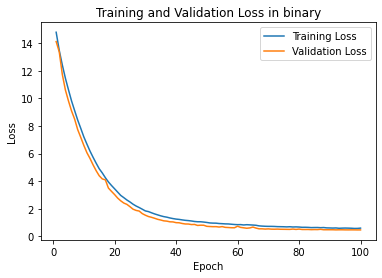

In [66]:
train_loss = history_binary.history['loss']
val_loss = history_binary.history['val_loss']

epochs_range = range(1, epochs + 1)

plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')

plt.legend()
plt.title('Training and Validation Loss in binary')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

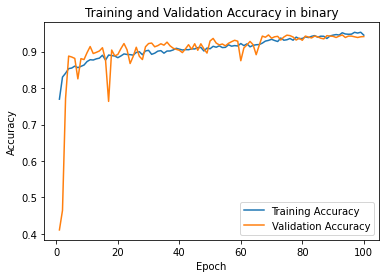

In [67]:
train_accuracy = history_binary.history['accuracy']
val_accuracy = history_binary.history['val_accuracy']

epochs_range = range(1, epochs + 1)

plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')

plt.legend()
plt.title('Training and Validation Accuracy in binary')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

评估不可见数据集的表现

In [95]:
model_binary.evaluate(test_isCancerous_generator)
# TODO: 添加二分类混淆矩阵评估

62/62 [==============================] - 2s 28ms/step - loss: 0.5177 - accuracy: 0.9328 - precision: 0.9123 - recall: 0.9204 - f1_score: 0.9163


[0.5177003145217896,
 0.9328283071517944,
 0.9122806787490845,
 0.9203540086746216,
 0.9162995219230652]

# 训练多分类

In [112]:
epochs = 100
history_categorical = model_categorical.fit(
    train_cellType_generator,
    steps_per_epoch=len(train_data) // batch_size,
    epochs=epochs,
    validation_data=val_cellType_generator,
    validation_steps=len(val_data) // batch_size,
    class_weight=class_weight_dict_cellType
    , callbacks=[lr_reducer]
)

Epoch 1/100
197/197 [==============================] - 12s 54ms/step - loss: 19.1581 - accuracy: 0.5543 - precision: 0.5917 - recall: 0.4984 - f1_score: 0.5411 - val_loss: 15.8573 - val_accuracy: 0.2136 - val_precision: 0.2114 - val_recall: 0.2060 - val_f1_score: 0.2087 - lr: 5.0000e-04
Epoch 2/100
197/197 [==============================] - 10s 51ms/step - loss: 16.8626 - accuracy: 0.6175 - precision: 0.6687 - recall: 0.5467 - f1_score: 0.6016 - val_loss: 13.1966 - val_accuracy: 0.5536 - val_precision: 0.5987 - val_recall: 0.5281 - val_f1_score: 0.5612 - lr: 5.0000e-04
Epoch 3/100
197/197 [==============================] - 10s 50ms/step - loss: 15.0133 - accuracy: 0.6521 - precision: 0.7154 - recall: 0.5781 - f1_score: 0.6395 - val_loss: 11.2607 - val_accuracy: 0.6614 - val_precision: 0.7313 - val_recall: 0.5797 - val_f1_score: 0.6467 - lr: 5.0000e-04
Epoch 4/100
197/197 [==============================] - 10s 52ms/step - loss: 13.4465 - accuracy: 0.6557 - precision: 0.7217 - recall: 0.

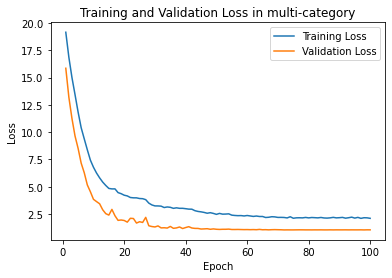

In [113]:
train_loss = history_categorical.history['loss']
val_loss = history_categorical.history['val_loss']

epochs_range = range(1, epochs + 1)

plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')

plt.legend()
plt.title('Training and Validation Loss in multi-category')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

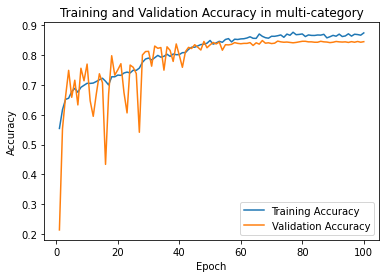

In [114]:
train_accuracy = history_categorical.history['accuracy']
val_accuracy = history_categorical.history['val_accuracy']

epochs_range = range(1, epochs + 1)

plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')

plt.legend()
plt.title('Training and Validation Accuracy in multi-category')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

In [179]:
# # 预测
# predictions = model_categorical.predict(test_cellType_generator)
#
# # 获取预测标签
# predicted_labels = np.argmax(predictions, axis=-1)
#
# # 计算准确度
# true_labels = test_cellType_generator.classes
# accuracy = accuracy_score(true_labels, predicted_labels)
# print(f"Accuracy: {accuracy}")
#
# # 计算损失
# y_true = tf.keras.utils.to_categorical(true_labels, num_classes=4) # 根据您的类别数量更改 num_classes
# loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_true, predictions))
# print(f"Loss: {loss}")

model_categorical.evaluate(test_cellType_generator)

62/62 [==============================] - 3s 44ms/step - loss: 1.1019 - accuracy: 0.8318 - precision: 0.8493 - recall: 0.8141 - f1_score: 0.8314


[1.1018544435501099,
 0.831818163394928,
 0.8493150472640991,
 0.8141413927078247,
 0.8313562870025635]

In [116]:
model_categorical.save('saved_model/model_categorical')

INFO:tensorflow:Assets written to: saved_model/model_categorical/assets


INFO:tensorflow:Assets written to: saved_model/model_categorical/assets


# DI/HD 使用data_labels_extraData对多分类的模型进行增强
通过半监督学习。我们将采用UDA。
首先先获取额外的数据集并且进行相关处理。
我们从数据集可以观察到，没有癌症在多分类中为2。所以我们可以将不是癌症的样本之间指定其多分类的类别为2.

In [209]:
model_categorical = tf.keras.models.load_model('saved_model/model_categorical', custom_objects={"F1Score": F1Score})
data_extra = pd.read_csv('./Image_classification_data/data_labels_extraData.csv')
data_extra['isCancerous'] = data_extra['isCancerous'].astype(str)
data_extra['cellType'] = np.nan
data_extra.loc[data_extra['isCancerous'] == '1', 'cellType'] = 2
data_extra_unlabeled = data_extra[data_extra['cellType'].isna()]
# data_extra_labeled = data_extra[data_extra['cellType'] == 2]
# undivided_train_data = pd.concat([undivided_train_data, data_extra_labeled], axis=0).reset_index(drop=True)
# undivided_train_data['cellType'] = undivided_train_data['cellType'].astype(int)
# train_data, val_data = train_test_split(undivided_train_data, test_size=0.2, random_state=42)

In [75]:
# cellType(多分类)的比例
# class_samples_cellType = train_data['cellType'].value_counts()
# total_samples = np.sum(class_samples_cellType)
# class_weights_cellType = total_samples / class_samples_cellType
# class_weight_dict_cellType = {int(k): v for k, v in class_weights_cellType.to_dict().items()}
#
# data_extra_unlabeled['isCancerous'] = data_extra_unlabeled['isCancerous'].astype(str)
# train_data['cellType'] = train_data['cellType'].astype(str)
# val_data['cellType'] = val_data['cellType'].astype(str)

重新生成新的train_generator

In [210]:
batch_size = 32
train_datagen = CustomImageDataGenerator(
    num_augmentations=3,
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.2,1.0],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_dataframe(
    train_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')

unlabeled_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

unlabeled_generator = unlabeled_datagen.flow_from_dataframe(
    data_extra_unlabeled,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='isCancerous', # 我们并不关心y_col。只是为了防止报错
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_data['cellType'] = test_data['cellType'].astype(str)
validation_cellType_generator = val_datagen.flow_from_dataframe(
    val_data,
    directory='./Image_classification_data/patch_images',
    x_col='ImageName',
    y_col='cellType',
    target_size=(27, 27),
    batch_size=batch_size,
    class_mode='categorical')

Found 6332 validated image filenames belonging to 4 classes.
Found 7394 validated image filenames belonging to 1 classes.
Found 1584 validated image filenames belonging to 4 classes.


## FixMatch 实现

In [211]:
# 定义数据增强层
class RandAugment(tf.keras.layers.Layer):
    def __init__(self, num_layers, magnitude, **kwargs):
        super().__init__(**kwargs)
        self.num_layers = num_layers
        self.magnitude = magnitude
        self.operations = [
            tf.keras.layers.RandomFlip("horizontal_and_vertical"),
            tf.keras.layers.RandomRotation(factor=(0.1 * magnitude, 0.1 * magnitude)),
            tf.keras.layers.RandomTranslation(height_factor=(-0.1 * magnitude, 0.1 * magnitude), width_factor=(-0.1 * magnitude, 0.1 * magnitude)),
            tf.keras.layers.RandomZoom(height_factor=(-0.1 * magnitude, 0.1 * magnitude), width_factor=(-0.1 * magnitude, 0.1 * magnitude)),
            tf.keras.layers.RandomContrast(factor=(1 - 0.1 * magnitude, 1 + 0.1 * magnitude)),
            tf.keras.layers.RandomBrightness(factor=(0.2 * magnitude)),
        ]

    def call(self, inputs, **kwargs):
        if kwargs.get('training'):
            for _ in range(self.num_layers):
                operation = random.choice(self.operations)
                inputs = operation(inputs, training=kwargs.get('training'))
        return inputs

In [212]:
def apply_fixmatch(x_batch, y_batch, x_unlabeled, model, optimizer, training=True, class_weight_dict=None, consistency_weight=1, confidence_threshold=0.95):
    # 计算模型在原始无标签数据和增强无标签数据上的输出
    with tf.GradientTape() as tape:
        if x_unlabeled is not None:
            # 对无标签数据进行数据增强
            # x_unlabeled_augmented = data_augmentation(x_unlabeled)
            rand_augment = RandAugment(num_layers=5, magnitude=0.9)
            x_unlabeled_augmented_strong = rand_augment(x_unlabeled, training=training)
            rand_augment = RandAugment(num_layers=1, magnitude=0.9)
            x_unlabeled_augmented_weak = rand_augment(x_unlabeled, training=training)
            y_pred_unlabeled_weak = model(x_unlabeled_augmented_weak)
            y_pred_unlabeled_augmented = model(x_unlabeled_augmented_strong)

            # Confidence-based masking
            max_probs = tf.reduce_max(y_pred_unlabeled_weak, axis=-1)
            mask = max_probs > confidence_threshold
            y_pred_unlabeled = tf.boolean_mask(y_pred_unlabeled_weak, mask)
            y_pred_unlabeled_augmented = tf.boolean_mask(y_pred_unlabeled_augmented, mask)

        y_pred_labeled = model(x_batch)
        # 计算有监督损失
        # 如果是训练并且给定了类别权重，则根据权重计算损失。
        if class_weight_dict is not None and training:
            sample_weights = tf.gather(class_weight_dict, tf.argmax(y_batch, axis=-1))
            supervised_loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_batch, y_pred_labeled) * sample_weights)
        else:
            supervised_loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_batch, y_pred_labeled))

        # 如果提供了无标签数据，则计算一致性损失，(半监督学习)
        if x_unlabeled is not None:
            consistency_loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_pred_unlabeled, y_pred_unlabeled_augmented))
            total_loss = supervised_loss + consistency_weight * consistency_loss
        else:
            total_loss = supervised_loss

        # 计算准确度
        accuracy = tf.keras.metrics.categorical_accuracy(y_batch, y_pred_labeled)

        # 计算Precision
        precision = tf.keras.metrics.Precision()
        precision.update_state(tf.argmax(y_batch, axis=-1), tf.argmax(y_pred_labeled, axis=-1))

        # 计算Recall
        recall = tf.keras.metrics.Recall()
        recall.update_state(tf.argmax(y_batch, axis=-1), tf.argmax(y_pred_labeled, axis=-1))

        # 计算F1分数
        f1_score = 2 * ((precision.result() * recall.result()) / (precision.result() + recall.result() + tf.keras.backend.epsilon()))

        if training:
            # 反向传播和优化
            grads = tape.gradient(total_loss, model_categorical.trainable_variables)
            optimizer.apply_gradients(zip(grads, model_categorical.trainable_variables))
    return total_loss, supervised_loss, consistency_loss if x_unlabeled is not None else None, accuracy, precision.result(), recall.result(), f1_score

### 训练半监督

In [213]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5)
epochs = 5
min_val_loss = float('inf')
num_epochs_no_improvement = 0
current_learning_rate = optimizer.learning_rate.numpy()
history = {"loss": [], "val_loss": [], "accuracy": [], "val_accuracy": [], "precision":[],
           "recall":[], "f1":[], "val_precision":[], "val_recall":[], "val_f1":[]}

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    total_loss = 0
    total_supervised_loss = 0
    total_consistency_loss = 0
    total_accuracy = 0
    total_precision = 0
    total_recall = 0
    total_f1_score = 0
    steps = 0

    total_batches = math.ceil(len(train_data) / batch_size)
    with tqdm(total=total_batches, desc="Training", ncols=100) as progress_bar:
        for (x_batch, y_batch), (x_unlabeled, _) in zip(train_generator, unlabeled_generator):
            progress_bar.update(1)
            loss, supervised_loss, consistency_loss, accuracy, precision, recall, f1_score = apply_fixmatch(x_batch,
                                                                                                            y_batch,
                                                                                                            x_unlabeled,

                                                                                                            model_categorical,
                                                                                                            optimizer,
                                                                                                            class_weight_dict_cellType)
            total_loss += loss
            total_supervised_loss += supervised_loss
            total_consistency_loss += consistency_loss
            total_precision += precision
            total_recall += recall
            total_f1_score += f1_score
            total_accuracy += tf.reduce_mean(accuracy)
            steps += 1
            # 检查是否已经处理了所有批次
            if steps * batch_size >= len(train_data):
                break

        # 计算并打印平均损失和准确率
        avg_loss = total_loss / steps
        avg_supervised_loss = total_supervised_loss / steps
        avg_consistency_loss = total_consistency_loss / steps
        avg_accuracy = total_accuracy / steps
        avg_precision = total_precision / steps
        avg_recall = total_recall / steps
        avg_f1_score = total_f1_score / steps

        history["loss"].append(avg_loss.numpy())
        history["accuracy"].append(avg_accuracy.numpy())
        history["precision"].append(avg_precision.numpy())
        history["recall"].append(avg_recall.numpy())
        history["f1"].append(avg_f1_score.numpy())
        print(f" - loss: {avg_loss.numpy():.4f}, supervised_loss: {avg_supervised_loss.numpy():.4f}, consistency_loss: {avg_consistency_loss.numpy():.4f}, accuracy: {avg_accuracy.numpy():.4f}, precision: {avg_precision.numpy():.4f}, recall: {avg_recall.numpy():.4f}, f1_score: {avg_f1_score.numpy():.4f}")

    total_loss = 0
    total_accuracy = 0
    total_recall = 0
    total_precision = 0
    total_f1_score = 0
    steps = 0
    for x_batch, y_batch in validation_cellType_generator:
        loss, _, _, accuracy, precision, recall, f1_score = apply_fixmatch(x_batch, y_batch, None, model_categorical, optimizer, False)
        total_loss += loss
        total_precision += precision
        total_recall += recall
        total_f1_score += f1_score
        total_accuracy += tf.reduce_mean(accuracy)
        steps += 1

        if steps * batch_size >= len(test_data):
            break

    avg_loss = total_loss / steps
    avg_accuracy = total_accuracy / steps
    avg_precision = total_precision / steps
    avg_recall = total_recall / steps
    avg_f1_score = total_f1_score / steps

    history["val_loss"].append(avg_loss.numpy())
    history["val_accuracy"].append(avg_accuracy.numpy())
    history["val_precision"].append(avg_precision.numpy())
    history["val_recall"].append(avg_recall.numpy())
    history["val_f1"].append(avg_f1_score.numpy())
    print(f"Validation set： - loss: {avg_loss.numpy():.4f}, accuracy: {avg_accuracy.numpy():.4f}, precision: {avg_precision.numpy():.4f}, recall: {avg_recall.numpy():.4f}, f1_score: {avg_f1_score.numpy():.4f}")

    # 检查是否需要更新学习率
    if avg_loss < min_val_loss:
        min_val_loss = loss
        num_epochs_no_improvement = 0
    else:
        num_epochs_no_improvement += 1

    if num_epochs_no_improvement >= 3:
        current_learning_rate *= np.sqrt(0.1)
        current_learning_rate = max(current_learning_rate, 0.5e-15)
        optimizer.learning_rate.assign(current_learning_rate)
        num_epochs_no_improvement = 0

Epoch 1/5


Training: 100%|███████████████████████████████████████████████████| 198/198 [00:35<00:00,  5.65it/s]

 - loss: 6.0741, supervised_loss: 0.3005, consistency_loss: 5.7735, accuracy: 0.8971, precision: 0.9728, recall: 0.9609, f1_score: 0.9661


Validation set： - loss: 0.4254, accuracy: 0.8553, precision: 0.9488, recall: 0.9628, f1_score: 0.9547
Epoch 2/5


Training: 100%|███████████████████████████████████████████████████| 198/198 [00:35<00:00,  5.61it/s]

 - loss: 5.2895, supervised_loss: 0.2922, consistency_loss: 4.9973, accuracy: 0.8997, precision: 0.9732, recall: 0.9671, f1_score: 0.9695


Validation set： - loss: 0.4441, accuracy: 0.8478, precision: 0.9459, recall: 0.9608, f1_score: 0.9525
Epoch 3/5


Training: 100%|███████████████████████████████████████████████████| 198/198 [00:35<00:00,  5.54it/s]

 - loss: 5.2431, supervised_loss: 0.3012, consistency_loss: 4.9419, accuracy: 0.8956, precision: 0.9697, recall: 0.9637, f1_score: 0.9660


Validation set： - loss: 0.4603, accuracy: 0.8478, precision: 0.9405, recall: 0.9678, f1_score: 0.9530
Epoch 4/5


Training: 100%|███████████████████████████████████████████████████| 198/198 [00:35<00:00,  5.56it/s]

 - loss: 5.2086, supervised_loss: 0.2986, consistency_loss: 4.9100, accuracy: 0.8944, precision: 0.9675, recall: 0.9664, f1_score: 0.9662


Validation set： - loss: 0.4433, accuracy: 0.8453, precision: 0.9413, recall: 0.9656, f1_score: 0.9525
Epoch 5/5


Training: 100%|███████████████████████████████████████████████████| 198/198 [00:34<00:00,  5.72it/s]

 - loss: 2.4640, supervised_loss: 0.3052, consistency_loss: 2.1588, accuracy: 0.8966, precision: 0.9667, recall: 0.9709, f1_score: 0.9681


Validation set： - loss: 0.4431, accuracy: 0.8508, precision: 0.9443, recall: 0.9690, f1_score: 0.9558


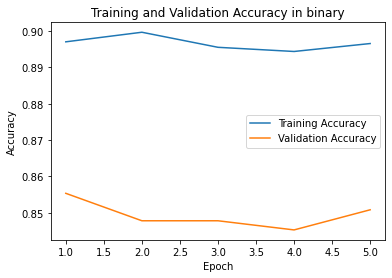

In [214]:
train_accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

epochs_range = range(1, epochs + 1)

plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')

plt.legend()
plt.title('Training and Validation Accuracy in binary')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show()

In [215]:
model_categorical.evaluate(test_cellType_generator)

62/62 [==============================] - 3s 43ms/step - loss: 1.0995 - accuracy: 0.8313 - precision: 0.8512 - recall: 0.8091 - f1_score: 0.8296


[1.0995135307312012,
 0.8313131332397461,
 0.8512220978736877,
 0.8090909123420715,
 0.8296219110488892]